# Section 6: An Intuitive Picture of Band Structure

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from IPython.display import display

In this Section, we are going to explore the emergence of band structure using simple models that you have studied before. We will consider a series of potential barriers (equally spaced) to simulate the periodic potential that electrons experience inside a crystal. By varying the heights of these barriers, we can smoothly transition between two simple limits: (1) a single, wide square well and (2) a series of narrow, uncoupled square wells. Band structure emerges between these two extremes. 

**Learning Goals**
After this Section, you should:

- Be able to explain the qualitative origins of energy bands
- Explain the origin of energy spacings *within* bands as compared to *between* bands
- Describe the shape of electronic wavefunctions at the edge of each Brillouin zone
- Explain the connection between bound state and scattering methods of characterizing the energy levels of the periodic potential

## Qualitative Solution

Before we dive into numerical solutions, let's think about the following qualitative situation: we have a square well of width $L$. Within the well, we place a series of barriers that partition the square well into $N$ narrower wells with width $a$. Each barrier has height $\beta$ and thickness $b$. 

Let's start by considering the barriers to be infinitely thin (basically, delta functions). Now, as a class, let's work through the following questions:

1. What are the energies and eigenstates of the wide well if the barriers are not present ($\beta=0$)?
2. When $\beta \rightarrow \infty$, what should the wavefunctions look like?
3. As we increase $\beta$ to take on finite values, what will happen to the wavefunctions? How will they look? What will their ordering be like relative to the cases we just described?
4. What analogies could we make between excitation of different bands and excitations of atoms in a solid?

After going through these qualitative arguments, we can now look at what the numerics tell us.

## Building the potential V(x)

First we'll write some functions that build our model potential. Our model includes the following parameters:

- $L$: width of the enclosing square well
- $a$: width of each narrow square well
- $b$: thickness of each internal barrier
- $N$: number of narrow square wells
- $\beta$: heigh of each barrier.



In [5]:
#| echo: false
# This function will return another function that depends only on x.
# That's a convenient way to get a function of x that can go into our DVR code.
# fullwidth allows us to embed the entire potential in a wider "framing" square well
def make_potential(N, a, b, beta):
    L = N*a+(N-2)*b
    if N > 0:
        x0s = np.arange(1,N)*(a+b)-(b) - L/2 # locations of barrier centers
        def fn(x):
            # builds a barrier of height beta and width b centered at each x0 value:
            barriers = beta*np.sum([np.heaviside(x-x0s[n]+b/2 , 0.5) - np.heaviside((x-x0s[n]-b/2), 0.5) for n in range(N-1)], axis=0)
            return barriers + beta * ((x < -L/2-b/2) | (x>L/2+b/2))
    else:
        a = L
        def fn(x):
            return np.zeros(len(x)) + beta * ((x < -L/2) | (x>L/2))
    
    return fn
    

Text(0, 0.5, 'V')

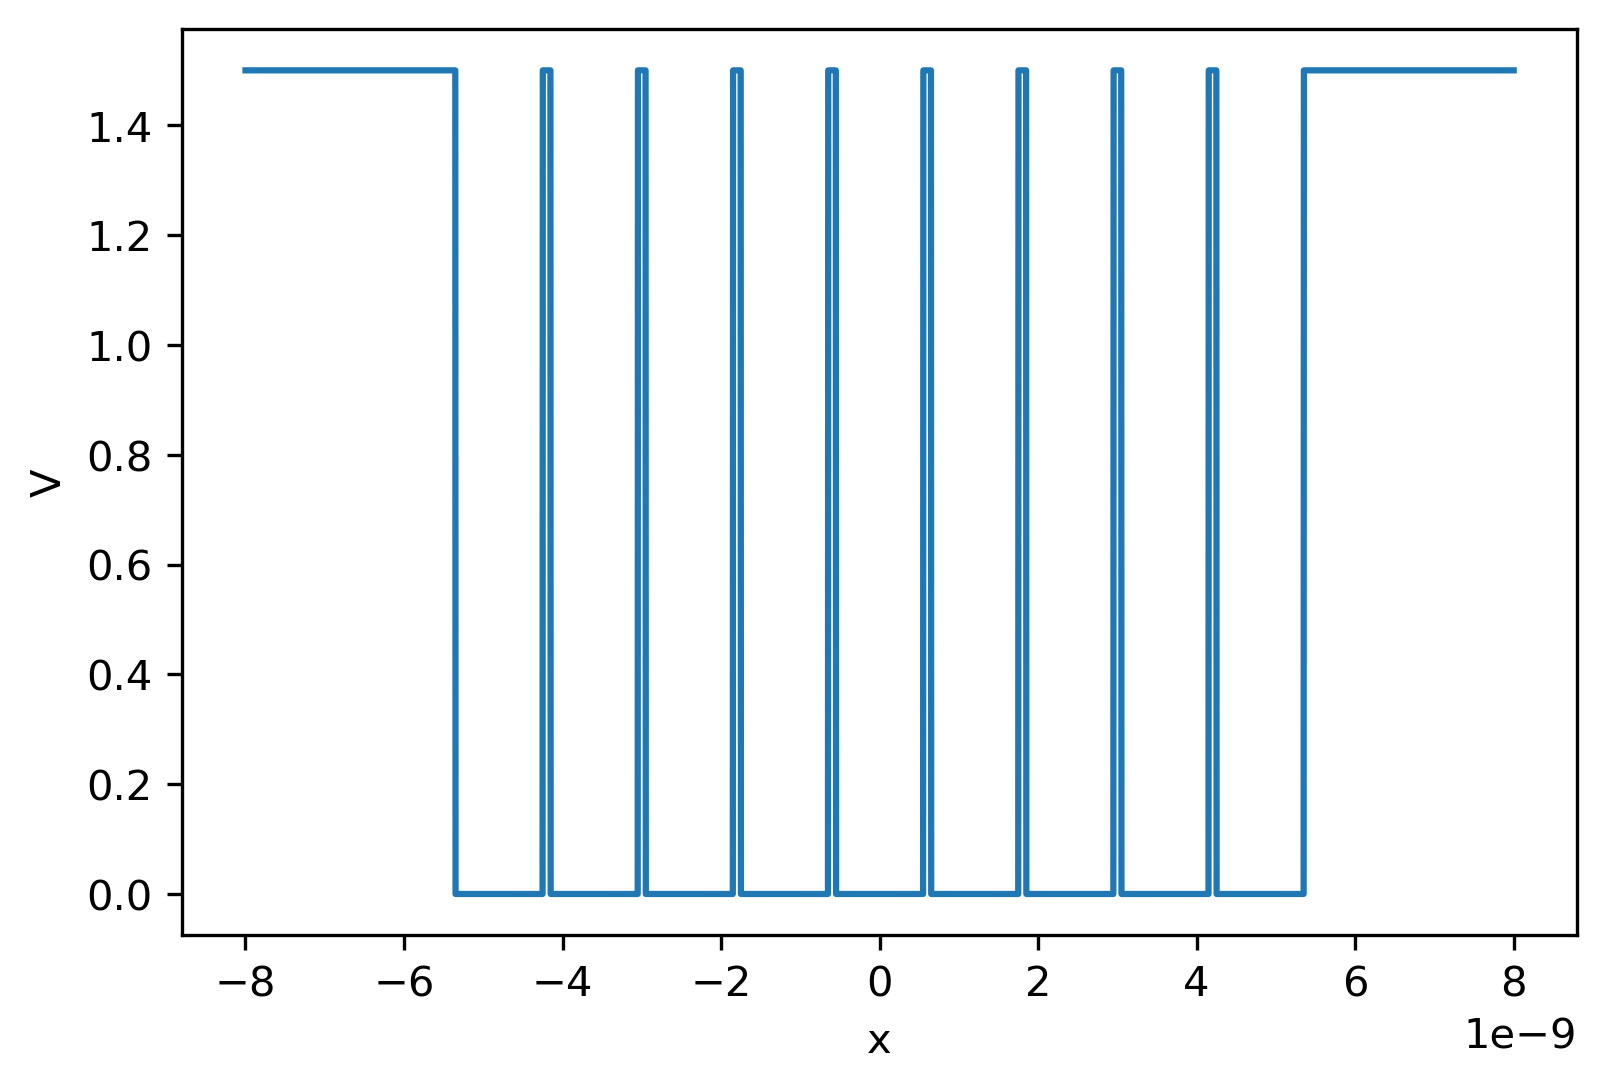

In [ ]:
#| echo: false
f_test = make_potential(9, 1.1e-9, 0.1e-9, 1.5)
x = np.linspace(-8,8, 5000)*1e-9
plt.plot(x,f_test(x).T)
plt.xlabel("x")
plt.ylabel("V");

## Making the DVR code

Next, we set up the DVR code from Section 4 to build the Hamiltonian for our system. This code is the same as we have used previously.

In [68]:
hbar = (6.63e-34)/(2*np.pi) # in J.s
m = 9.1e-31 # in kg

# Function to make the kinetic energy operator
def make_T(x):
    Delta_x = x[1]-x[0]
    N = x.shape[0]
    Tmat = np.zeros((N,N))
    
    # now loop over kinetic energy matrix and fill in matrix elements
    for i in range(N):
        for j in range(N):
            if i==j:
                Tmat[i,j] = (hbar**2/(2*m*Delta_x**2)) * (np.pi**2)/3
            else:
                Tmat[i,j] = (hbar**2/(2*m*Delta_x**2)) * (-1)**(i-j) * 2/(i-j)**2
                
    return Tmat
  
# Function to make the potential energy operator
def make_V(x,Vfunc):
    Vmat = np.diag(Vfunc(x))
    return Vmat

# Function to make the full Hamiltonian
def make_H(x,Vfunc):
    return make_T(x) + make_V(x,Vfunc)

Let's test this on a potential consisting of 12 wells that are fairly deep. After building the potential, we construct the Hamiltonian, evaluate the eigenvectors/eigenvalues, and then plot.

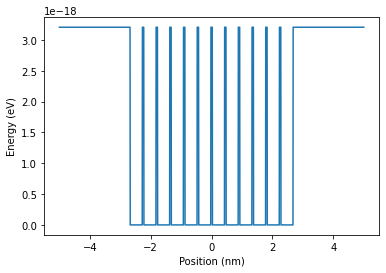

In [ ]:
N = 12 # number of wells
a = 0.4e-9
b = 0.05e-9 # wall thickness in nm
beta = 20 / 6.24150907e18 # well height in J
V_wells = make_potential(N, a, b, beta)
xs = np.linspace(-5, 5, 1600)*1e-9
plt.plot(xs*1e9, V_wells(xs))
plt.xlabel("Position (nm)")
plt.ylabel("Energy (eV)")

Ham=make_H(xs,V_wells)

vals, vecs = np.linalg.eigh(Ham)
# make sure ground state is upward going
vecs[:,0] = vecs[:,0] * np.sign(vecs[np.argmax(np.abs(vecs[:,0])),0])
# number of bound states:
nbound = np.sum([vals<beta])

We can now plot the numerically computed eigenvalues. Let's overlay these values with the energy levels that would occur if there were no barriers inside the potential---the energy levels of the "wide" finite square well.

In [39]:
def analytical_Es(w):
    return [i**2 * np.pi**2 * hbar**2/(2*m*w**2) for i in range(1,nbound+1)]

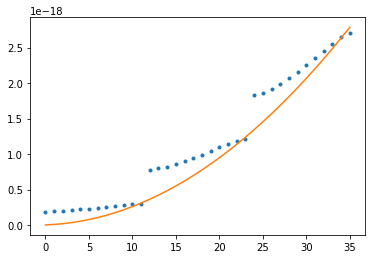

In [40]:
plt.plot(vals[:nbound],'.')
plt.plot(analytical_Es(N*a+(N-2)*b))

Notice that the periodic potential leads to a structure highly reminiscient of band structure: the energy levels roughly follow the parabolic shape expected from the wide square well (or, from a different perspective, for the free particle), but the levels are broken up into bands with the characteristic shape that we see in class. And there are band gaps between these bands.

**Question: What will the plot look like if we increase the well separation to the point that the wells are essentially fully uncoupled? Will there be energy degeneracies? How many levels will share the same energy? What happens as the number of wells is increased--which energy gaps "close" and which remain?**

To answer these questions, perform a "numerical experiment" and compare your results to the appropriate square well. How do the numbers compare?

**Question: What happens if the well separation is decreased to essentially zero? How do these energies compare to the appropriate finite square well? What about the comparison to free particle energies?**

Let's look at the wavefunctions to understand this even better. It will be useful to plot the actual wavefunctions and have some interactivity. The code below makes a plot with a slider that allows you to look at all of the bound eigenstates for a given potential. Once you set the number of wells, their width, and their barriers, you can scan through the eigenstates and look at the behavior.

In [53]:
def interact_wavefunction():        
    ## Plot parameters
    xmin, xmax, nx = min(xs)*1e9, max(xs)*1e9, 50
    ymin, ymax = -1.2, 1.2
    pmin, pmax, pstep, pinit = 0, nbound-1, 1, 0
    
    ## Set up the plot data
    fig, (ax1,ax2)   = plt.subplots(1,2,figsize=(16,6))
    line2, = ax1.plot(xs*1e9,2*V_wells(xs)/np.max(V_wells(xs))-1, color="grey")
    line, = ax1.plot([], [], linewidth=2, color="red") # Initialize curve to empty data.
    
    well_levels, = ax2.plot([],[])
    well_itself, = ax2.plot([],[], color="black")

    ## Set up the figure axes, etc.
    ax1.set_xlim([xmin, xmax])
    ax1.set_ylim([ymin, ymax])
    ax2.set_xlim([xmin,xmax])
    ax2.set_ylim([-beta/8*6.24150907e18,1.2*beta*6.24150907e18])
    ax1.set_xlabel('Position (nm)', fontsize=18)
    ax1.set_ylabel('Re{$\psi$}', fontsize=18)
    ax2.set_xlabel('Position (nm)', fontsize=18)
    ax2.set_ylabel('Energy (eV)', fontsize=18)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.close()      # Don't show the figure yet.

    ## Callback function
    def plot_wavefunction(Eigenstate):
        y = vecs[:,int(Eigenstate)]/np.max(np.abs(vecs[:,int(Eigenstate)]))
        line.set_data(xs*1e9, y)
        line2.set_data(xs*1e9, 2*V_wells(xs)/np.max(V_wells(xs))-1)
        well_itself.set_data(xs*1e9, V_wells(xs)*6.24150907e18)
        [ax2.axhline(y=vals[i]*6.24150907e18,color="grey") for i in range(nbound)]
        ax2.axhline(y=vals[int(Eigenstate)]*6.24150907e18, color="cyan")
        ax2.set_title(f"E={np.round(vals[int(Eigenstate)]*6.24150907e18,3)} eV", fontsize=16)
        display(fig)

    ## Generate the user interface.
    interact(plot_wavefunction, 
             Eigenstate=FloatSlider(min=pmin, max=pmax, step=pstep, value=pinit))


For example, we can start with 12 wells that are each 0.8 nm wide, 4 eV high, and have a 0.05 nm barrier between them. For this set of parameters, use the interactive plotting to gain some insights about the potential.

In [54]:
N = 12 # number of wells
a = 0.8e-9
b = 0.05e-9 # wall thickness in nm
beta = 4 / 6.24150907e18 # well height in J
V_wells = make_potential(N, a, b, beta)
xs = np.linspace(-8, 8, 900)*1e-9

Ham=make_H(xs,V_wells)

vals, vecs = np.linalg.eigh(Ham)
# make sure ground state is upward going
vecs[:,0] = vecs[:,0] * np.sign(vecs[np.argmax(np.abs(vecs[:,0])),0])
# number of bound states:
nbound = np.sum([vals<beta])


interact_wavefunction();

interactive(children=(FloatSlider(value=0.0, description='Eigenstate', max=32.0, step=1.0), Output()), _dom_cl…

**Question: Using the interactive graphs above, how does the behavior of each wavefunction within a single band conform to our expectations from Bloch's theorem? How do the wavefunctions differ from band to band? What do you expect to happen as $N \rightarrow \infty$?**

## Transfer matrix approach

There's a totally different way to look at band structure: by studying the scattering properties of the potential. This is a complementary method to learn about a potentials bound states. Scattering studies are widely used in many fields of physics/chemistry, from studying the solid state to studying atoms and molecules. Let's see what we can learn about electronic band structure from this point of view using the transfer matrix program that you wrote on HW2. 

First of all, let's go over the idea of the transfer matrix approach.

**Set up approach, talk about different role of propagation vs. transmission matrices.**

The code to implement each of these matrices is copied below.

In [55]:
def DMat(k1, k2):
    res = np.zeros((2,2),dtype=np.complex_)
    res[0,0] = (1 + k2/k1)/2
    res[0,1] = (1 - k2/k1)/2
    res[1,0] = res[0,1]
    res[1,1] = res[0,0]
    return res

def PMat(k, L):
    res = np.zeros((2,2),dtype=np.complex_)
    res[0,0] = np.exp(-1j * k * L)
    res[1,1] = np.exp(1j * k * L)
    return res

**Question: What do the peaks here represent? What is the physics going on when N=2? N=3? Large N?**

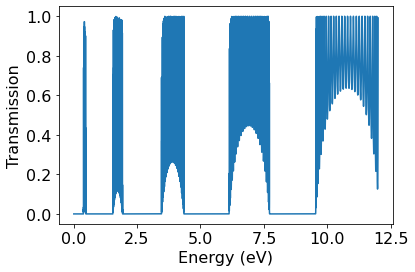

In [248]:
a = 0.8e-9
b = 0.1e-9

Es = np.arange(0.01, 12.0, 0.001) / 6.24150907e18
width_barrier = b
width_gap = a
Vb=10/ 6.24150907e18

Nwells=30


Ttrans = np.zeros(Es.size)
i = 0
for E in Es:
    klow = np.emath.sqrt(2 * m * E/hbar**2)
    khigh = np.emath.sqrt(2 * m * (E - Vb)/hbar**2)
    res_mat = DMat(klow, khigh) @ PMat(khigh, width_barrier) @ DMat(khigh, klow) @ PMat(klow, width_gap)
    U, V = np.linalg.eig(res_mat)
    diag_res_mat = np.diag([U[0],U[1]])
    res_mat = np.linalg.matrix_power(diag_res_mat,Nwells)
    res_mat = V @ res_mat @ np.linalg.inv(V)
    Ttrans[i] = 1 - np.abs(res_mat[1, 0])**2 / np.abs(res_mat[0,0])**2
    i = i + 1

plt.plot(Es * 6.24150907e18, Ttrans)
plt.xlabel("Energy (eV)",fontsize=16)
plt.ylabel("Transmission",fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

Let's compare the transmission peaks to the bound state energy of our finite square well.

In [249]:
V_wells = make_potential(Nwells, a, b, Vb)
xs = np.linspace(-15, 15, 1500)*1e-9

Ham=make_H(xs,V_wells)

vals, vecs = np.linalg.eigh(Ham)

Now let's compare the transmission fraction to the band energies. 

**Question: How can we easily determine the limits of each energy band? (How does it compare to the number of wells being simulated?**

(0.0, 10.0)

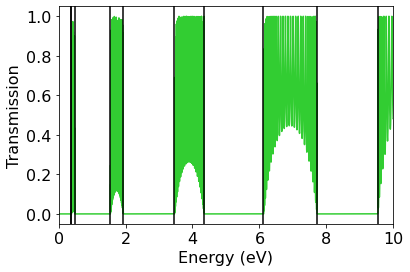

In [261]:
band_limits = [0]
for n in range(5):
    band_limits.append(n*Nwells-1)
    band_limits.append(n*Nwells)

plt.plot(Es * 6.24150907e18, Ttrans, color="limegreen")
[plt.axvline(vals[i]*6.24150907e18, color="black") for i in band_limits]
plt.xlabel("Energy (eV)",fontsize=16)
plt.ylabel("Transmission",fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlim(0,10)